# [강화 시스터즈] SARSA 실습

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1aVIHjGqCYCI_Y6x6ym4PZiDtwGUOTdVx

## SARSA
다음 환경(**GridWorldEnvironment**)을 가지고 SARSA를 구현하세요.

In [ ]:
%pip install numpy matplotlib 

## GridWorldEnvironment

```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [2]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치

        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

In [3]:
env = GridWorldEnvironment(start_point=(0,0), #위 환경 클래스를 상속 받아 `env.render` 코드를 구현
                           end_point=(4,4),
                           grid_world_size=(5,5))

# SARSA Class

In [4]:
import numpy as np

class MySARSAEnv(GridWorldEnvironment):
  def __init__(self, start_point, end_point, grid_world_size, alpha=0.1, gamma=0.1, epsilon=0.1):
    super().__init__(start_point, end_point, grid_world_size)
    self.env = self
    self.alpha = alpha # learning rate
    self.gamma = gamma # discount (낮을수록 현재 보상을, 1에 가까울수록 미래 보상을 중요하게 여김)
    self.epsilon = epsilon # exploration rate (최적 기대값 외 다른 행동도 일정 확률로 선택, 탐험)
    # Q 테이블 초기화 (상태-행동)
    self.Qtable = {}
    for state in self.total_states:
      for a in range(len(self.action_space)):
        self.Qtable[(state,a)] = 0.0

  def choose_action(self, state): # 행동 선택 함수
    if np.random.rand() < self.epsilon: # 무작위(0~1) 수가 epsilon보다 작으면 탐험, 크면 활용
      return np.random.choice(range(len(self.action_space))) # 행동 랜덤하게 선택
    else:
      qs = [self.Qtable[(state,a)] for a in range(len(self.action_space))]
      return np.argmax(qs) # 최대 기대값의 행동 반환

  def learn(self, state, action, reward, next_state, next_action):
    # 0값 업데이트 (SARSA)
    current_q = self.Qtable[(state, action)]
    next_state_q = self.Qtable[(next_state, next_action)]
    self.Qtable[(state, action)] += self.alpha * (reward + self.gamma * next_state_q - current_q)

  def run_sarsa(self, episode = 20):
    for ep in range(episode):
      state = self.start_point
      self.env.traces = [state]
      action = self.choose_action(state)

      while True:
        reward = self.get_reward(state, action)
        next_state = self.state_after_action(state, action)
        next_action = self.choose_action(next_state)
        self.env.traces.append(next_state)

        self.learn(state, action, reward, next_state, next_action)
        state = next_state
        action = next_action

        if next_state == self.end_point:
          break

      print(f"Episode: {ep+1} complete")
      self.render()

## Main

- **SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

In [5]:
env1 = MySARSAEnv(start_point=(0,0),
                  end_point=(4,4),
                  grid_world_size=(5,5))

env1.run_sarsa()

env2 = MySARSAEnv(start_point=(0,0),
                  end_point=(4,4),
                  grid_world_size=(5,5))

env2.run_sarsa()

Episode: 1 complete
S X X X X 
X X X X X 
X X X X X 
X X X X X 
. . . . A 

Episode: 2 complete
S X X X X 
X X X X X 
X X X X X 
X X X X X 
. . . . A 

Episode: 3 complete
S X X X X 
X X X X X 
X X . . X 
. . . . X 
. . . . A 

Episode: 4 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 5 complete
S X X X X 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

Episode: 6 complete
S X X X X 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

Episode: 7 complete
S X X X X 
X X . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 8 complete
S X X X X 
X X . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 9 complete
S X X X X 
X . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 10 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 11 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 12 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 13 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode:

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 complete
S X X X X 
. . . X X 
. . . . X 
. . . . X 
. . . . A 

Episode: 1 c

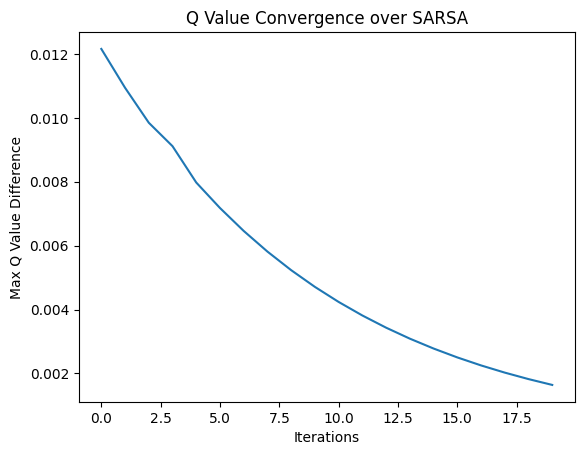

In [6]:
import copy
import matplotlib.pyplot as plt

max_iterations = 20
q_diff_list = []  # 기대값 또는 Q값 차이 기록

for i in range(max_iterations):
    old_Q_table = copy.deepcopy(env2.Qtable)  # 이전 Q값 저장

    env2.run_sarsa(1)  # 1회 반복마다 기대값 업데이트 수행

    # Q값 차이 최대값 계산
    max_diff = 0
    for key in env2.Qtable:
        s, a = key
        q_val = env2.Qtable[key]
        old_q_val = old_Q_table.get(key, 0)
        diff = abs(q_val - old_q_val)
        max_diff = max(max_diff, diff)
    q_diff_list.append(max_diff)

    if max_diff < 1e-4:
        print("Q값 수렴 완료")
        break

# 기대값 차이 그래프
plt.plot(q_diff_list)
plt.xlabel("Iterations")
plt.ylabel("Max Q Value Difference")
plt.title("Q Value Convergence over SARSA")
plt.show()